# Brazilian Securities

---

### Wilson Freitas


# Brazilian Securities

---

### Wilson Freitas

# Lecture 1

- A bit of history
    - Inflation in Brazil
    - Interest rates in Brazil
- Calendars
- Compounding Regimes
- DI1 Future
- DI x PRE Curve
- Interpolation
- Forward Rates
- COPOM Meetings

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bcb import currency, sgs
import bizdays

from myfuncs import get_contracts

## A bit of history

### Inflation in Brazil

- Inflation in Brazil used to be very high (hiper inflation)
- Inflation has been controled after the Real Economic Plan (which introduces the new currency Brazilian Real) at 1994-July
    - 1986 is the year of BM&F Foundation

In [2]:
ipca = sgs.get(('IPCA', 433), start_date='1986-01-01')

In [3]:
ipca.head()

,IPCA
date,
1986-01-01,14.37
1986-02-01,12.72
1986-03-01,4.77
1986-04-01,0.78
1986-05-01,1.40


- These are **monthly rates**.

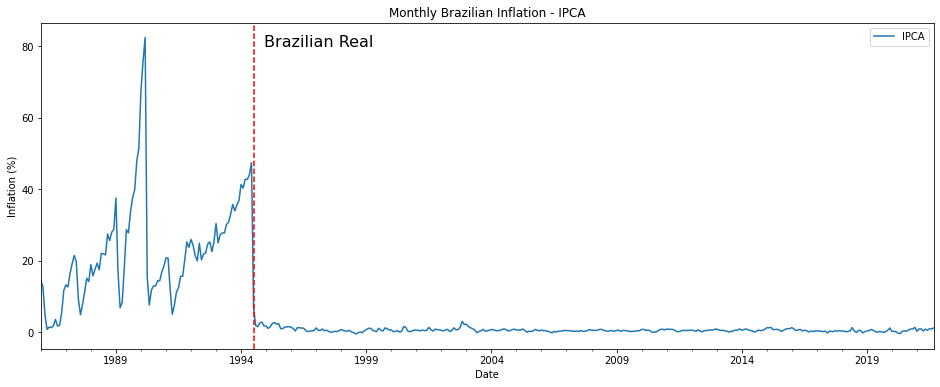

In [4]:
ipca.plot(xlabel='Date', ylabel='Inflation (%)', title='Monthly Brazilian Inflation - IPCA', figsize=(16, 6))
plt.axvline(x=pd.to_datetime('1994-07-01'), ls='--', color='red') # Brazilian Real
plt.text(pd.to_datetime('1994-12-01'), 80, 'Brazilian Real', fontsize=16)
plt.show()

- Rigth after the Brazilian Real (1994-1999) the Brazilian Central Bank used to use USD to control the Inflation

- In the period, 1994-1999, the Brazilian Real suffered many attacks and in the begining of 1999 the Brazilian Central Bank implemented the [Inflation Targeting](https://www.bcb.gov.br/en/monetarypolicy/Inflationtargeting)
    - The Inflation Targeting tries to control the Inflation by setting the level of the short term interest rate (SELIC)

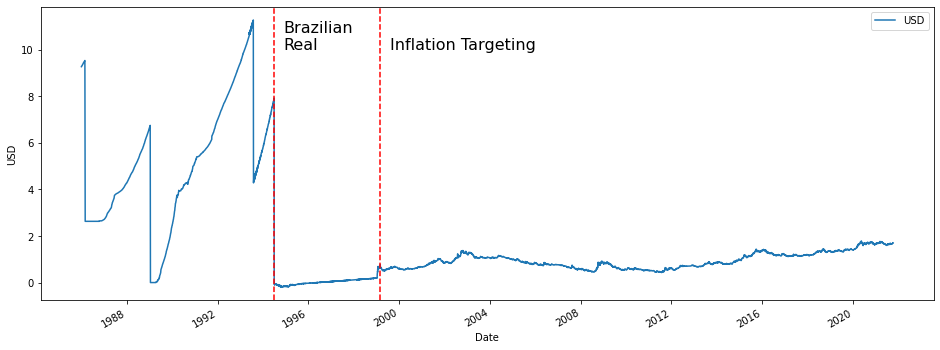

In [5]:
usd = currency.get('USD', start_date='1986-01-01', end_date='2021-10-05')
np.log(usd).plot(xlabel='Date', ylabel='USD', figsize=(16, 6))
plt.axvline(x=pd.to_datetime('1994-07-01'), ls='--', color='red') # Brazilian Real
plt.text(pd.to_datetime('1994-12-01'), 10, 'Brazilian\nReal', fontsize=16)
plt.axvline(x=pd.to_datetime('1999-03-01'), ls='--', color='red') # Inflation Targeting
plt.text(pd.to_datetime('1999-08-01'), 10, 'Inflation Targeting', fontsize=16)
plt.show()

### Interest Rates in Brazil

Most important interest rates in Brazil:

- CDI (Certificado de Depósitos Interbancários) - overnight interbank rate for unsecured lending and borrowing
- SELIC - overnight rate for secured lending and borrowing
- SELICTARGET - SELIC target rate
    - The SELICTARGET is defined by the Brazilian Central Bank in the COPOM meetings
    - The SELICTARGET is used to control the Inflation

- The SELIC target is avalilable since 1999, when Brazil adopted the Inflation Targeting

In [6]:
seta = sgs.get({'SELICTARGET': 432})

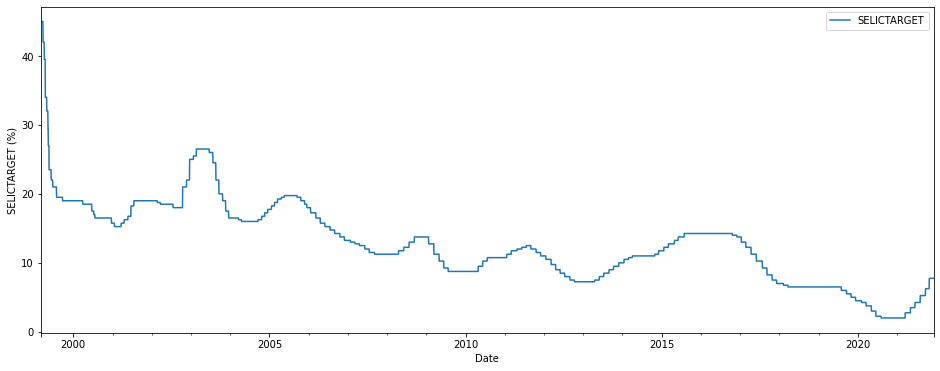

In [7]:
seta.plot(ylabel='SELICTARGET (%)', xlabel='Date', figsize=(16, 6));

In [8]:
dfs = sgs.get({'SELIC': 1178, 'CDI': 4389}, start_date = '1986-07-04')
rates = pd.concat(dfs, axis=1)

In [9]:
rates.head()

,SELIC,CDI
date,,
1986-07-04,23.31,26.56
1986-07-07,23.35,27.26
1986-07-08,23.30,27.15
1986-07-09,23.69,27.40
1986-07-10,23.91,27.66


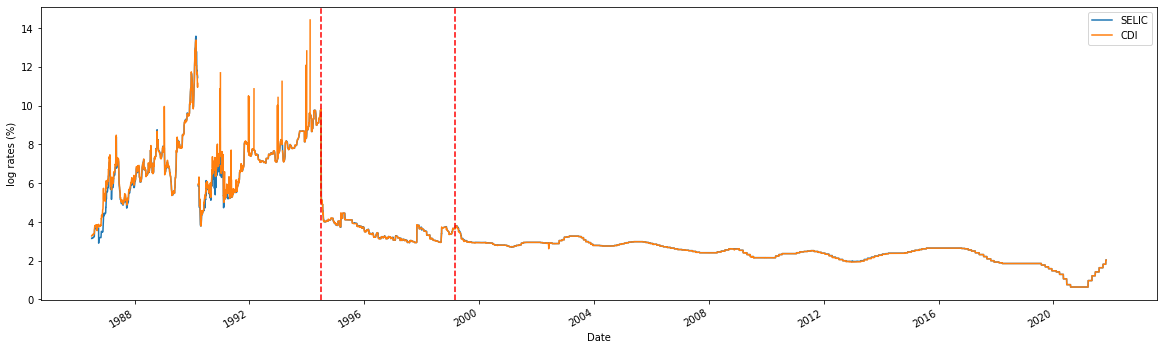

In [10]:
np.log(rates).plot(ylabel='log rates (%)', xlabel='Date', figsize=(20, 6))
plt.axvline(x=pd.to_datetime('1994-07-01'), ls='--', color='red') # Brazilian Real
plt.axvline(x=pd.to_datetime('1999-03-01'), ls='--', color='red') # COPOM Inflation Targeting
plt.show()

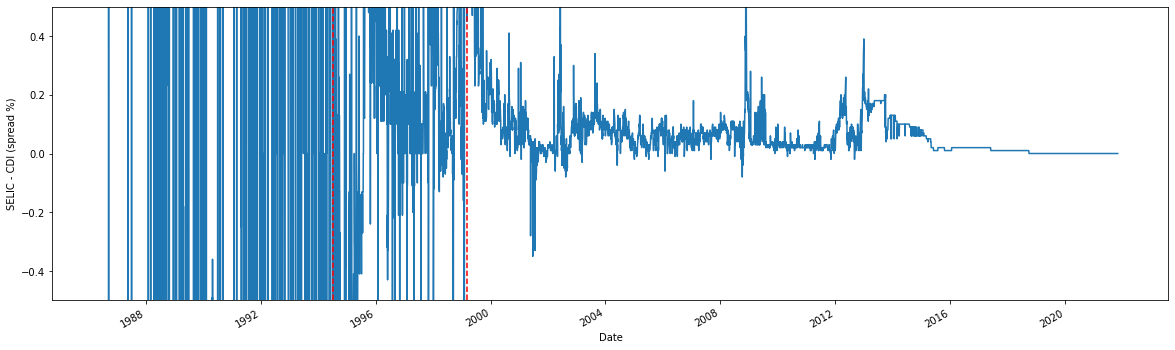

In [11]:
(rates['SELIC'] - rates['CDI']).plot.line(ylabel='SELIC - CDI (spread %)', xlabel='Date', figsize=(20, 6), ylim=(-0.5, 0.5));
plt.axvline(x=pd.to_datetime('1994-07-01'), ls='--', color='red') # Brazilian Real
plt.axvline(x=pd.to_datetime('1999-03-01'), ls='--', color='red') # COPOM Inflation Targeting
plt.show()

## Calendars

In Brazil we have the following calendars:

- ANBIMA: used in all fixed income (debêntures, futures), interest rate options and options on currency futures
- B3: used in stock options pricing
- actual (calendar days): bonds and futures in foreign currencies and a few bonds in BRL (mostly CDBs)

In [12]:
cal = bizdays.Calendar(name='actual')
print('Calendar actual:', cal.bizdays('2021-11-05', '2021-11-12'))

cal = bizdays.Calendar.load('ANBIMA.cal')
print('Calendar ANBIMA:', cal.bizdays('2021-11-05', '2021-11-12'))


Calendar actual: 7
Calendar ANBIMA: 5


## Compounding Regimes used in Brazil

### Exponential (discrete) compounding

$$
F(T) = P(t)(1 + r(t,T))^{\frac{D(t,T)}{252}}
$$

- $F(T)$: future value at $T$
- $P(t)$: amount invested or present value at time $t$
- $r(t,T)$: annual interest rate
- $D(t,T)$: number of business days between $T$ and $t$ according to a calendar

> Exponential compounding is used with great majority of interest rates in Brazil.
>
> Consequences of high levels of rates in recent past


In [13]:
cal = bizdays.Calendar.load('ANBIMA.cal')

P = 1000
r = 0.07
D = cal.bizdays('2021-11-05', '2021-11-12')
F = P*(1 + r)**(D/252)
print('Future value = ', F)


Future value =  1001.343334968659


### Simple compounding

$$
F(T) = P(t)(1 + r(t,T) \times \frac{D(t,T)}{360})
$$

- $F(T)$: future value at $T$
- $P(t)$: amount invested or present value at time $t$
- $r(t,T)$: annual interest rate
- $D(t,T)$: number of days between $T$ and $t$ (does not consider holidays and weekends)

> Simple compounding is used to compound princial in foreign currencies


In [14]:
cal = bizdays.Calendar(name='actual')

P = 1000
r = 0.02
D = cal.bizdays('2021-11-05', '2021-11-12')
F = P*(1 + r*(D/360))
print('Future value = ', F)


Future value =  1000.388888888889


## DI1 Future

- DI1 stands for **One-day Interbank Deposit Futures**.
- This is an interest rate **future contract** on the DI rate (CDI) delivered by B3 daily.

### How it works

- DI rate is an annual rate delivered daily
- DI rate is compounded in business days (252 days per year)
- Compounding this daily rate from an initial date $t$ and up to a date $T$ in the future we have an interest rate $r(t,T)$

$$
(1 + r(t,T))^{DU(t,T)/252} = \Pi_{i=t}^{T}(1 + DI_i)^{1/252}
$$

- $r(t,T)$ brings the expectation of the way the future DI rates will evolve.
- $DU(t,T)$ is the amount of business days between $t$ and $T$

This expectation, $r(t,T)$, is exactly what the DI1 Future trades.

**Long DI1 Future position**

- Short in floating rate (daily DI rate) compounded up to contract maturity
- Long in fixed spot rate related to contract maturity

> So if the spot rate related to contract maturity goes up you have a loss, otherwise you have a gain.

**Short DI1 Future position**

- Long in floating rate (daily DI rate) compounded up to contract maturity
- Short in fixed spot rate related to contract maturity

> So if DI rate (short term daily rate) goes up you have a gain, otherwise you have a loss.


### Pricing

- For this reason we price the DI1 Future as a bullet bond.
- $r(t,T)$ is commonly called **PRE** because we call fixed rate as **Prefixada**

$$
PU_{fixed}(DU(t,T)) = \frac{100000}{(1 + r(t,T))^{DU(t,T)/252}}
$$

where

- $t$: current instant of time (reference date)
- $T$: maturity date (date when the contract expires)
- $DU(t,T)$: the amount of business days between maturity and reference dates, according to specific calendar delivered by ANBIMA
- $r(t,T)$: spot interest rate between reference date and contract maturity


### Data

- [Future Settlements](https://www.b3.com.br/en_us/market-data-and-indices/data-services/market-data/historical-data/derivatives/trading-session-settlements/)
- [Search by trading session](https://www.b3.com.br/en_us/market-data-and-indices/data-services/market-data/historical-data/newsletters/search-by-trading-session/search-by-trading-session/)

In [15]:
refdate = datetime.datetime(2021, 11, 1)
df = get_contracts(refdate)

In [16]:
di1 = df[(df['Mercadoria'] == 'DI1') & (df['PUAtual'] != 100000.0)].copy()
di1

,DataRef,Mercadoria,CDVencimento,PUAnterior,PUAtual,Variacao,Vencimento
194,2021-11-01,DI1,Z21,99414.97,99415.20,0.23,2021-12-01
195,2021-11-01,DI1,F22,98636.12,98636.23,0.11,2022-01-01
196,2021-11-01,DI1,G22,97890.57,97889.46,-1.11,2022-02-01
197,2021-11-01,DI1,H22,97094.37,97092.79,-1.58,2022-03-01
198,2021-11-01,DI1,J22,96087.30,96084.73,-2.57,2022-04-01
199,2021-11-01,DI1,K22,95257.43,95205.71,-51.72,2022-05-01
200,2021-11-01,DI1,M22,94180.86,94127.01,-53.85,2022-06-01
201,2021-11-01,DI1,N22,93188.96,93134.41,-54.55,2022-07-01
202,2021-11-01,DI1,Q22,92202.13,92134.77,-67.36,2022-08-01
203,2021-11-01,DI1,U22,91158.99,91076.66,-82.33,2022-09-01


### Maturity Code

```
F - Jan
G - Feb
H - Mar
J - Apr
K - May
M - Jun
N - Jul
Q - Aug
U - Sep
V - Oct
X - Nov
Z - Dez
```

### DI1 Futures Term Structure

- The Interest Rate Term Structure is obtained from Settlement Prices.
- The rates come from the pricing formula.

$$
r(t,T) = \left( \frac{100000}{PU_{fixed}(DU(t,T))} \right)^{252/DU(t,T)} - 1
$$



In [17]:
MARKET_CALENDAR = bizdays.Calendar.load('ANBIMA.cal')
di1['Maturity'] = di1['Vencimento'].map(MARKET_CALENDAR.following)
di1['DU'] = di1.apply(lambda x: MARKET_CALENDAR.bizdays(x['DataRef'], x['Maturity']), axis=1)
di1['Rate'] = (100000 / di1['PUAtual'])**(252 / di1['DU']) - 1
di1_curve = di1[['DataRef', 'Maturity', 'DU', 'Rate']]

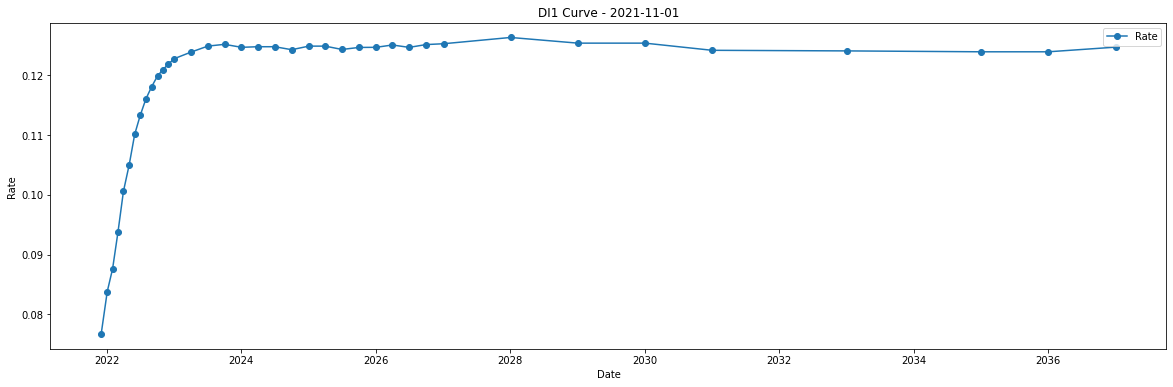

In [18]:
di1_curve.plot(x='Maturity', y='Rate', figsize=(20,6), style='-o',
               ylabel='Rate', xlabel='Date', title='DI1 Curve - 2021-11-01');

* Let's see the recent effect of the excess of expenses discussed by the government

In [19]:
refdate = datetime.datetime(2021, 10, 1)
df = get_contracts(refdate)
di1 = df[(df['Mercadoria'] == 'DI1') & (df['PUAtual'] != 100000.0)].copy()
di1['Maturity'] = di1['Vencimento'].map(MARKET_CALENDAR.following)
di1['DU'] = di1.apply(lambda x: MARKET_CALENDAR.bizdays(x['DataRef'], x['Maturity']), axis=1)
di1['Rate'] = (100000 / di1['PUAtual'])**(252 / di1['DU']) - 1
di1_curve_sep = di1[['DataRef', 'Maturity', 'DU', 'Rate']]

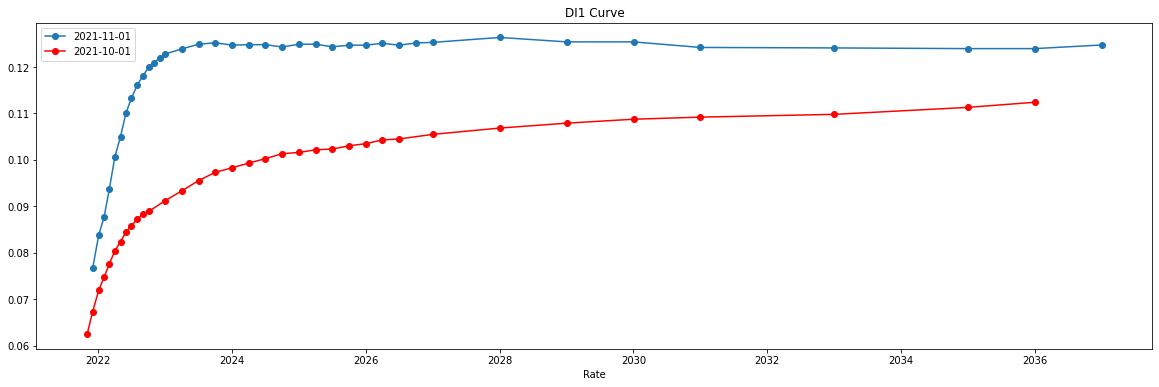

In [20]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('DI1 Curve')
plt.plot(di1_curve['Maturity'], di1_curve['Rate'], '-o')
plt.plot(di1_curve_sep['Maturity'], di1_curve_sep['Rate'], '-o', color='red');
plt.legend(['2021-11-01', '2021-10-01'])
plt.show()

## Interpolation


* Linear interpolation used with foreign rates (rates that use simple compounding)

* Exponential Flat-Forward interpolation used with all other rates that use exponential compounding


### Exponential Flat-Forward Interpolation

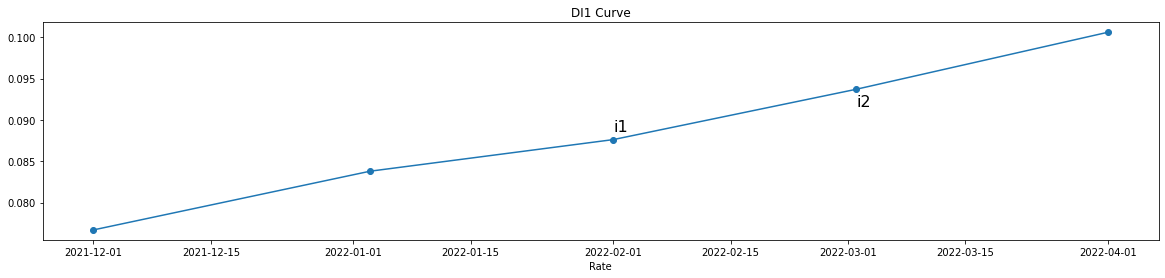

In [21]:
di1_curve_h = di1_curve.reset_index(drop=True).head()
plt.figure(figsize=(20,4))
plt.xlabel('Rate')
plt.title('DI1 Curve')
plt.plot(di1_curve_h['Maturity'], di1_curve_h['Rate'], '-o')
plt.text(di1_curve_h.loc[2, 'Maturity'], di1_curve_h.loc[2, 'Rate'] + 0.001, 'i1', fontsize=16)
plt.text(di1_curve_h.loc[3, 'Maturity'], di1_curve_h.loc[3, 'Rate'] - 0.002, 'i2', fontsize=16)
plt.show()

* Between $i_1$ and $i_2$ there is a forward rate $fwd$

$$
(1 + i_2)^{T_2} = (1 + i_1)^{T_1} \cdot (1 + fwd)^{T_2 - T_1}
$$  

* The Exponential Flat-Forward interpolation assumes that the forward rate between $i_1$ and $i_2$ is flat

* Any $i_x$ between $i_1$ and $i_2$ can be found as

$$
(1 + i_x)^{T_x} = (1 + i_1)^{T_1}\cdot(1 + fwd)^{T_x-T_1}
$$


* We can show that Exponential Flat-Forward interpolation is equivalent to a Linear interpolation on the log of compound factor

$$
\begin{split}
\log{(1 + i_x)^{T_x}} &= \log{(1 + i_1)^{T_1}} + \log{(1 + fwd)^{T_x-T_1}} \\
I_x &= I_1 + I_{fwd} \\
I_x &= I_1 + \frac{T_x - T_1}{T_2 - T_1} (I_2 - I_1)\end{split}
$$

* We have

$$
I_x = \log{(1 + i_x)^{T_x}}
$$

* And so

$$
i_x = \frac{\exp{I_x}}{T_x} - 1
$$


In [22]:
log_pu = np.log((1 + di1_curve_h['Rate'])**(di1_curve_h['DU']/252))
terms = di1_curve_h['DU']
i_terms = np.array(range(terms.min(), terms.max()))
pu = np.exp(np.interp(i_terms, terms, log_pu))
i_curve = pd.DataFrame({
    'DU': i_terms,
    'Maturity': MARKET_CALENDAR.vec.offset('2021-11-01', i_terms),
    'Rate': pu ** (252 / i_terms) - 1
})

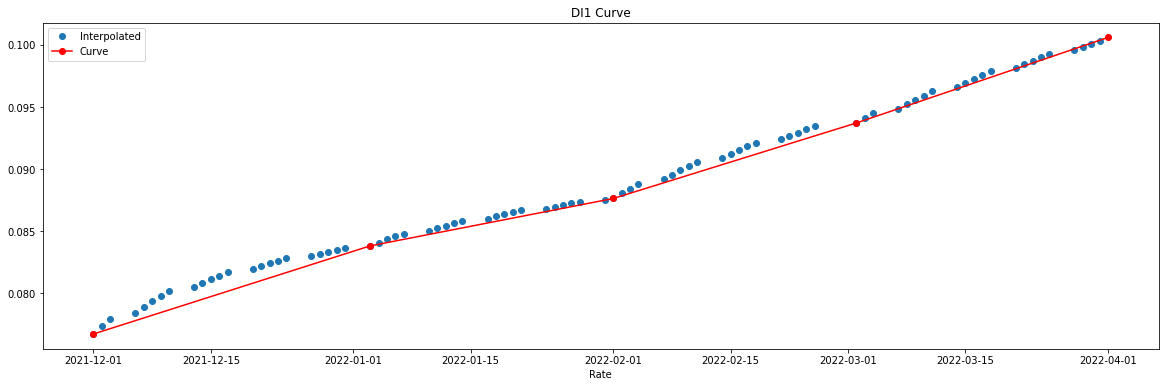

In [23]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('DI1 Curve')
plt.plot(i_curve['Maturity'], i_curve['Rate'], 'o')
plt.plot(pd.to_datetime(di1_curve_h['Maturity']), di1_curve_h['Rate'], '-o', color='red');
plt.legend(['Interpolated', 'Curve'])
plt.show()

- We use the daily DI rate as the first point of the curve

In [24]:
cdi = sgs.get(('CDI', 4389), start_date='2021-11-01', end_date='2021-11-01')
cdi

,CDI
date,
2021-11-01,7.65


In [25]:
first_term = pd.DataFrame({
    'DataRef': datetime.datetime(2021,11,1),
    'Maturity': ['2021-11-03'],
    'DU': [1],
    'Rate': [cdi.iloc[0, 0]/100]
})

In [26]:
di1_curve_h = pd.concat([first_term, di1_curve_h], axis=0).reset_index(drop=True)
di1_curve_h

,DataRef,Maturity,DU,Rate
0,2021-11-01,2021-11-03,1,0.07650
1,2021-11-01,2021-12-01,20,0.07670
2,2021-11-01,2022-01-03,43,0.08380
3,2021-11-01,2022-02-01,64,0.08762
4,2021-11-01,2022-03-02,83,0.09371
5,2021-11-01,2022-04-01,105,0.10060


In [27]:
log_pu = np.log((1 + di1_curve_h['Rate'])**(di1_curve_h['DU']/252))
terms = di1_curve_h['DU']
i_terms = np.array(range(terms.min(), terms.max()))
pu = np.exp(np.interp(i_terms, terms, log_pu))
i_curve = pd.DataFrame({
    'DU': i_terms,
    'Maturity': MARKET_CALENDAR.vec.offset('2021-11-01', i_terms),
    'Rate': pu ** (252 / i_terms) - 1
})

In [28]:
i_curve

,DU,Maturity,Rate
0,1,2021-11-03,0.076500
1,2,2021-11-04,0.076605
2,3,2021-11-05,0.076641
3,4,2021-11-08,0.076658
4,5,2021-11-09,0.076669
...,...,...,...
99,100,2022-03-25,0.099297
100,101,2022-03-28,0.099568
101,102,2022-03-29,0.099833
102,103,2022-03-30,0.100094


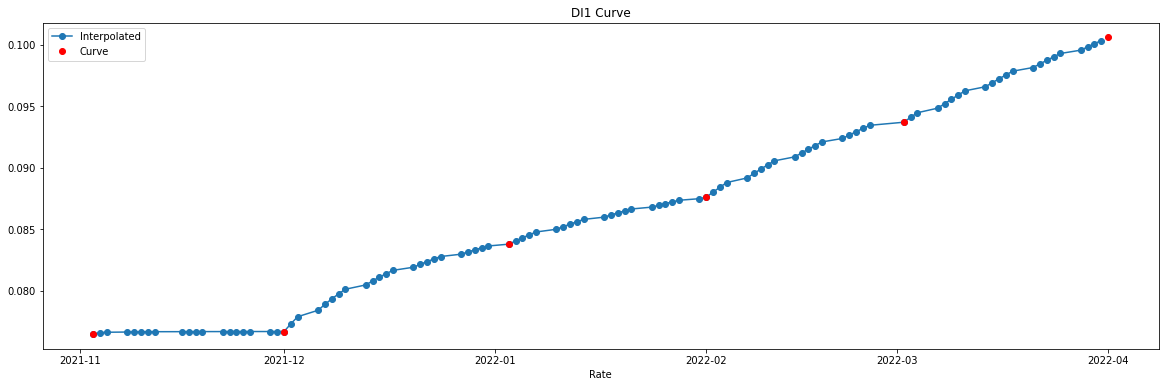

In [29]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('DI1 Curve')
plt.plot(i_curve['Maturity'], i_curve['Rate'], '-o')
plt.plot(pd.to_datetime(di1_curve_h['Maturity']), di1_curve_h['Rate'], 'o', color='red');
plt.legend(['Interpolated', 'Curve'])
plt.show()

##  Forward Rates

$$
(1 + i_2) ^ {T_{2}} = (1 + i_1) ^ {T_{1}} (1 + i_{12}) ^ {T_{12}}
$$

* This is true if $T_{12}$ is 1 year or 1 day
* The daily forward rates implied in the term structure are an estimate for the future daily rates

In [30]:
i_curve

,DU,Maturity,Rate
0,1,2021-11-03,0.076500
1,2,2021-11-04,0.076605
2,3,2021-11-05,0.076641
3,4,2021-11-08,0.076658
4,5,2021-11-09,0.076669
...,...,...,...
99,100,2022-03-25,0.099297
100,101,2022-03-28,0.099568
101,102,2022-03-29,0.099833
102,103,2022-03-30,0.100094


In [31]:
i_curve['Factor'] = (1 + i_curve['Rate'])**(i_curve['DU']/252)
i_curve['Factor_p'] = i_curve['Factor'].shift(1)
i_curve['FwdRate'] = (i_curve['Factor']/i_curve['Factor_p'])**252 - 1

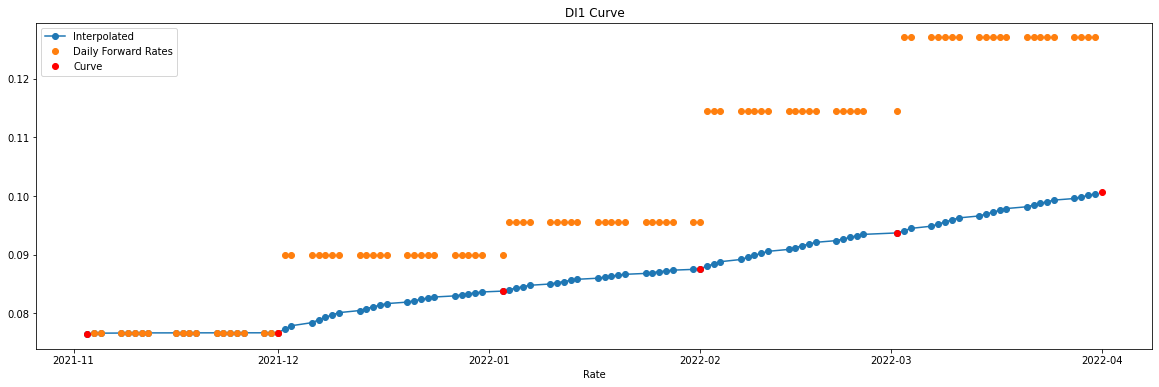

In [32]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('DI1 Curve')
plt.plot(i_curve['Maturity'], i_curve['Rate'], '-o')
plt.plot(i_curve['Maturity'], i_curve['FwdRate'], 'o')
plt.plot(pd.to_datetime(di1_curve_h['Maturity']), di1_curve_h['Rate'], 'o', color='red');
plt.legend(['Interpolated', 'Daily Forward Rates', 'Curve'])
plt.show()

## COPOM Meetings

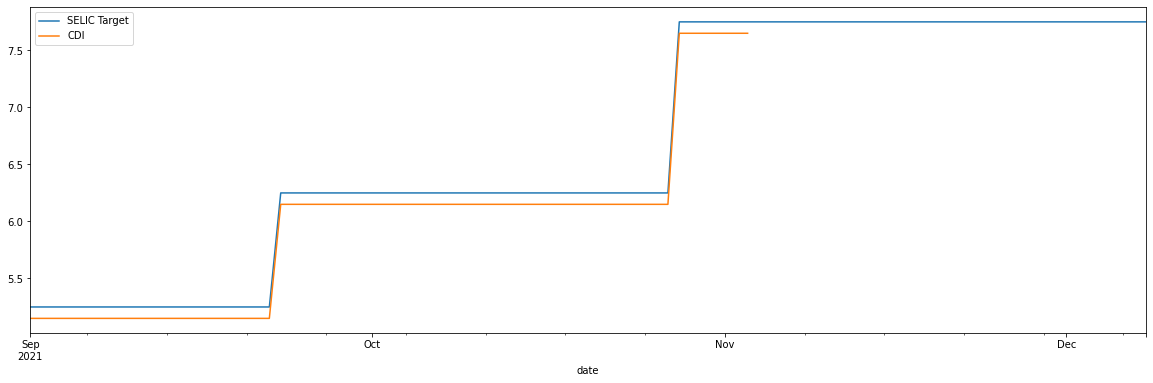

In [33]:
seta.loc['2021-09-01':,:].plot(figsize=(20,6));
rates.loc['2021-09-01':,'CDI'].plot();
plt.legend(['SELIC Target', 'CDI']);

In the same chart:

- Historical SELIC Target
- Daily Forward Rates

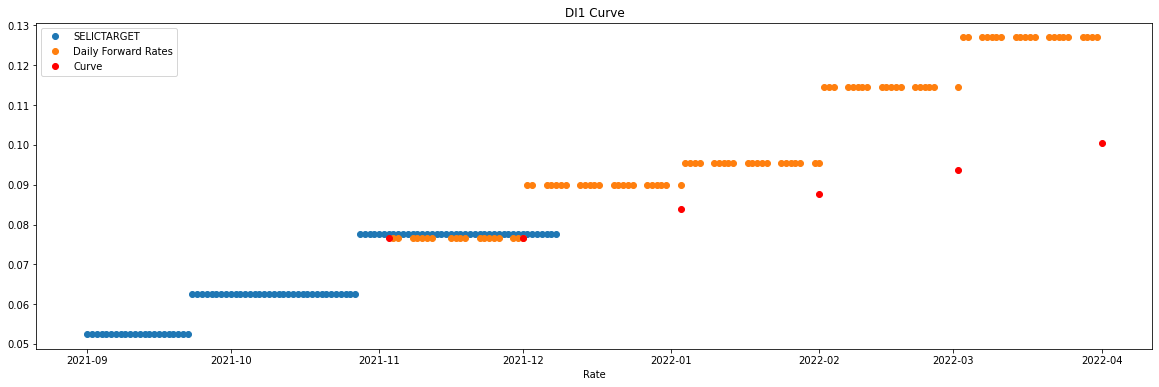

In [34]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('DI1 Curve')
plt.plot(seta.loc['2021-09-01':,'SELICTARGET'].index, seta.loc['2021-09-01':,'SELICTARGET']/100, 'o')
plt.plot(i_curve['Maturity'], i_curve['FwdRate'], 'o')
plt.plot(pd.to_datetime(di1_curve_h['Maturity']), di1_curve_h['Rate'], 'o', color='red');
plt.legend(['SELICTARGET', 'Daily Forward Rates', 'Curve'])
plt.show()

### COPOM Meetings considerations

* Is is a good idea to consider the COPOM Meetings in the interpolation.
* Specially the **first meeting** that is more clear and presents a direct result.